In [1]:
import numpy as np
import networkx as nx
import algorithms
import evaluate

In [2]:
def list_minus(x, y):
    return list(set(x) - set(y))

# TODO: parallelize assignment sampling
# TODO: ensure that coarse graph is not disconnected (i.e. every node is within some r-ball)

def landmark_partition(A, num_landmark, radius, affinity_fn, K=2):
    """ Compute k-way partition coarsening the input graph into balls """
    n = A.shape[0]
    # 1. Choose landmark points
    L = np.random.choice(n, size=num_landmark, replace=False)
    # 2. Compute distances within radius r
    D = np.zeros((n, num_landmark))
    for i in range(num_landmark):
        U_old = []
        U = [L[i]]
        for r in range(1, radius+1):
            U_comp = np.array(list_minus(np.arange(n), U)) # Complement of U
            A_sub = A[np.ix_(U, U_comp)] # Submatrix from U to its complement          
            neighbors = list_minus(U_comp[np.max(A_sub, axis=0)>0], U_old) # Seen nodes cannot be new neighbors
            U, U_old = neighbors, U
            if len(U) == 0:
                break            
            D[list(U), i] = affinity_fn(r) 


    # Overwrite rows for landmark points, such that they get assigned deterministically (weight probto infty)
    # (Alternative: don't sample for landmark points at all)
    D[L] = np.eye(num_landmark)
    # TODO: Ensure that every point is within some ball
    assert np.min(np.max(D, axis=1)) > 0, 'Too few/ small balls: there are points in no ball'
    
    # 3. Assign vertices to landmark points
    P = 1 / D.sum(axis=1, keepdims=True) * D
    cell_ixs = list(np.zeros(n))
    # TODO: parallelize
    for i in range(n):
        cell_ixs[i] = np.random.choice(a=L, p=P[i])
        
    # 4. Define coarsened-graph
    node_weights = np.zeros(num_landmark)
    A_coarse = np.zeros((num_landmark, num_landmark))
    for i in range(num_landmark):
        node_weights[i] = cell_ixs.count(L[i])
    for i in range(num_landmark):
        for j in range(i+1, num_landmark):
            A_coarse[i, j] = A[np.ix_(cell_ixs==L[i], cell_ixs==L[j])].sum()
    A_coarse += A_coarse.T
    # 5. Partition ball-graph
    x_coarse = algorithms.compute_spectral_wcut(A=A_coarse, w=node_weights, K=K)
    # 6. Project partition to input graph
    x = np.zeros(n)
    for i in np.where(x_coarse==1)[0]:
        x[np.array(cell_ixs)==L[i]] = 1
    return x

In [637]:
for num_landmark in [20]:    
    x = landmark_partition(A=A, num_landmark=num_landmark, radius=3, affinity_fn= lambda x: 1/x, K=2)
    
    print(f'{num_landmark} balls of fractions: {evaluate.evaluate_SBM_partition(x=x, sizes=sizes)}')

20 balls of fractions: [0.38, 0.4, 0.57, 0.44]


In [336]:
import copy

def graph_growing_partition(A, num_landmarks, choose_neighbor_fn, K=2):
    """Compute K-way partition coarsening the input graph into growing regions."""
    A = copy.deepcopy(A) # Don't want to destroy input matrix
    n = A.shape[0]
    node_sets = [{v} for v in np.arange(n)]
    # 1. Choose landmark points
    landmarks = np.random.choice(n, size=num_landmarks, replace=False)        
    # 2. Loop until converged    
    while len(node_sets) > num_landmarks:
    # 3. Choose neighbors for all landmark points
        for i in range(num_landmarks):
            neighbor = choose_neighbor_fn(base_node=landmarks[i], forbidden_neighbors=landmarks, A=A)
    # 4. Merge nodes to obtain new graph
            if neighbor is not None:
                A, node_sets, landmarks = merge_edge(base_node=landmarks[i], node_to_merge=neighbor, A=A, 
                                                node_sets=node_sets, landmarks=landmarks)
    # 5. Partition coarsened graph
    x_coarse = algorithms.compute_spectral_wcut(A=A, w=np.array([len(V) for V in node_sets]), K=K)
    # 6. Project partition to input graph
    if K == 2:
        x = np.zeros(n)
        for i in np.where(x_coarse==1)[0]:
            x[list(node_sets[i])] = 1
    else:
        x = np.zeros((K, n))
        for k in range(K):
            for i in np.where(x_coarse[k]==1)[0]:
                x[k, list(node_sets[i])] = 1
    return x

In [337]:
def choose_neighbor_uniform(base_node, forbidden_neighbors, A):
    allowed_neighbors = list_minus(np.where(A[base_node] > 0)[0], forbidden_neighbors)
    neighbor = None
    if len(allowed_neighbors) > 0:
        neighbor = np.random.choice(a=allowed_neighbors)
    return neighbor

def choose_neighbor_weighted(base_node, forbidden_neighbors, A):
    allowed_neighbors = list_minus(np.where(A[base_node] > 0)[0], forbidden_neighbors)
    neighbor = None
    if len(allowed_neighbors) > 0:
        weights = A[base_node, allowed_neighbors]
        neighbor = np.random.choice(a=allowed_neighbors, p=weights / weights.sum())
    return neighbor

def choose_neighbor_maxweight(base_node, forbidden_neighbors, A):
    allowed_neighbors = list_minus(np.where(A[base_node] > 0)[0], forbidden_neighbors)
    neighbor = None
    if len(allowed_neighbors) > 0:
        weights = A[base_node, allowed_neighbors]
        neighbor = allowed_neighbors[np.argmax(weights)]
    return neighbor

def merge_edge(base_node, node_to_merge, A, node_sets, landmarks):
    # Update adjacency matrix
    A[base_node] += A[node_to_merge]
    A[:, base_node] += A[node_to_merge]
    A[base_node, base_node] = 0
    A = np.delete(A, node_to_merge, axis=0)
    A = np.delete(A, node_to_merge, axis=1)
    # Update node sets
    node_sets[base_node] = node_sets[base_node].union(node_sets[node_to_merge])
    del node_sets[node_to_merge]
    # Update landmarks
    landmarks = [l - (l > node_to_merge) for l in landmarks]
    return A, node_sets, landmarks

# Test on SBM

In [354]:
sizes = np.array([1500, 500])
p_within = .3
p_between = .05
p = p_between * np.ones((len(sizes), len(sizes)))
np.fill_diagonal(p, p_within)
G = nx.stochastic_block_model(sizes=sizes, p=p)
A = nx.to_numpy_array(G)

/Users/lrendsburg/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


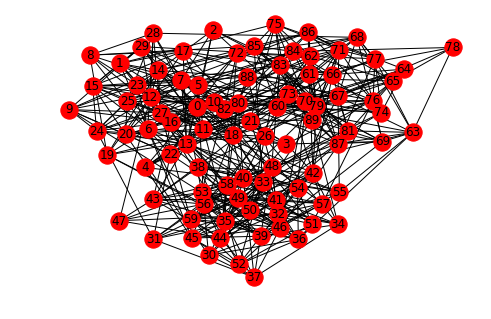

In [305]:
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True)

In [295]:
def diff_fractions(l):
    return(np.abs(l[0] - l[1]))

In [347]:
names = ['Uniform', 'Weighted', 'Max']
for j, choose_neighbor_fn in enumerate([choose_neighbor_uniform, choose_neighbor_weighted, choose_neighbor_maxweight]):
    print(f'Choosing strategy: {names[j]}')
    for num_landmarks in [2, 20, 50, 100]:
        diff = []
        for i in range(1):
            x = graph_growing_partition(A=A, num_landmarks=num_landmarks, 
                                        choose_neighbor_fn=choose_neighbor_fn)
            diff.append(diff_fractions(evaluate.evaluate_SBM_partition(x=x, sizes=sizes)))
        print(f'num_landmarks={num_landmarks}: frac_diff={np.array(diff).mean()}')

Choosing strategy: Uniform
num_landmarks=2: frac_diff=0.018000000000000016
num_landmarks=20: frac_diff=0.122
num_landmarks=50: frac_diff=0.1499999999999999
num_landmarks=100: frac_diff=0.314
Choosing strategy: Weighted
num_landmarks=2: frac_diff=0.07800000000000001
num_landmarks=20: frac_diff=0.244
num_landmarks=50: frac_diff=0.508
num_landmarks=100: frac_diff=0.534
Choosing strategy: Max
num_landmarks=2: frac_diff=0.998
num_landmarks=20: frac_diff=0.694
num_landmarks=50: frac_diff=0.41800000000000004
num_landmarks=100: frac_diff=0.01200000000000001


In [357]:
for num_landmarks in [2, 3, 4, 5, 10, 20, 50, 100]:
    x = graph_growing_partition(A=A, num_landmarks=num_landmarks, 
                                        choose_neighbor_fn=choose_neighbor_maxweight)
    frac = evaluate.evaluate_SBM_partition(x=x, sizes=sizes)
    frac_diff = diff_fractions(frac)
    print(f'num_landmarks={num_landmarks}, frac={frac}, frac_diff={frac_diff}')

/Users/lrendsburg/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


num_landmarks=2, frac=[0.49866666666666665, 0.504], frac_diff=0.005333333333333357
num_landmarks=3, frac=[0.334, 0.332], frac_diff=0.0020000000000000018
num_landmarks=4, frac=[0.75, 0.75], frac_diff=0.0
num_landmarks=5, frac=[0.5993333333333334, 0.602], frac_diff=0.002666666666666595
num_landmarks=10, frac=[0.9993333333333333, 0.202], frac_diff=0.7973333333333332
num_landmarks=20, frac=[0.0013333333333333333, 0.596], frac_diff=0.5946666666666667
num_landmarks=50, frac=[1.0, 0.92], frac_diff=0.07999999999999996
num_landmarks=100, frac=[0.9946666666666667, 0.696], frac_diff=0.29866666666666675


In [356]:
for num_landmarks in [2, 3, 4, 5, 10, 20, 50, 100]:
    x = graph_growing_partition(A=A, num_landmarks=num_landmarks, 
                                        choose_neighbor_fn=choose_neighbor_weighted)
    frac_diff = diff_fractions(evaluate.evaluate_SBM_partition(x=x, sizes=sizes))
    print(f'num_landmarks={num_landmarks}, frac_diff={frac_diff}')

/Users/lrendsburg/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


num_landmarks=2, frac_diff=0.005333333333333357
num_landmarks=3, frac_diff=0.033333333333333326
num_landmarks=4, frac_diff=0.07200000000000006
num_landmarks=5, frac_diff=0.09599999999999997
num_landmarks=10, frac_diff=0.09333333333333338
num_landmarks=20, frac_diff=0.05066666666666664
num_landmarks=50, frac_diff=0.10133333333333328
num_landmarks=100, frac_diff=0.2686666666666667


In [303]:
for num_landmarks in [2, 10, 50, 100]:
    diff = []
    for i in range(10):
        x = graph_growing_partition(A=A, num_landmarks=num_landmarks, 
                                    choose_neighbor_fn=choose_neighbor_weighted)
        diff.append(diff_fractions(evaluate.evaluate_SBM_partition(x=x, sizes=sizes)))
    print(f'num_landmarks={num_landmarks}: frac_diff={np.array(diff).mean()}')

Choosing landmarks
Growing regions
Partitioning coarse graph
Backproject partition
Choosing landmarks
Growing regions
Partitioning coarse graph
Backproject partition
Choosing landmarks
Growing regions
Partitioning coarse graph
Backproject partition
Choosing landmarks
Growing regions
Partitioning coarse graph
Backproject partition
Choosing landmarks
Growing regions
Partitioning coarse graph
Backproject partition
Choosing landmarks
Growing regions
Partitioning coarse graph
Backproject partition
Choosing landmarks
Growing regions
Partitioning coarse graph
Backproject partition
Choosing landmarks
Growing regions
Partitioning coarse graph
Backproject partition
Choosing landmarks
Growing regions
Partitioning coarse graph
Backproject partition
Choosing landmarks
Growing regions
Partitioning coarse graph
Backproject partition
num_landmarks=2: frac_diff=0.08660000000000001
Choosing landmarks
Growing regions
Partitioning coarse graph
Backproject partition
Choosing landmarks
Growing regions
Parti

In [339]:
for num_landmarks in [30]:
    x = graph_growing_partition(A=A, num_landmarks=num_landmarks, 
                                choose_neighbor_fn=choose_neighbor_weighted,
                                K=3)
    for k in range(3):
        print(f'num_landmarks: {num_landmarks}, fractions={evaluate.evaluate_SBM_partition(x=x[k], sizes=sizes)}')

num_landmarks: 30, fractions=[0.09, 0.01, 0.0]
num_landmarks: 30, fractions=[0.03, 0.0, 0.07]
num_landmarks: 30, fractions=[0.03, 0.03, 0.04]
